# On Analyzing Real World Time Series for Forecasting Stock Data - Tencent Returns Data

In [1]:
from collections import namedtuple
from data_loader import build_stock_uts
from ts_models import Model, PersistenceWalkForward, AR, MA, ARMA, EvaluationMetric
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Stock Data Analysis

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data
11. Split Returns Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
15. Initialize Moving Average `MA(p, q)` Model
16. Predict Forecasts for Returns Data
17. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
18. Initialize Autoregressive Moving Average `ARMA(p, q)` Model
19. Predict Forecasts for Returns Data
20. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
21. Initialize `Persistence Random Walk` Model
22. Predict Forecasts for Returns Data
23. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
24. Follow-up

### Load Raw Data

In [39]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2010-01-05", "2023-11-10"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("TCEHY", "Tencent"),
    ("INTC", "Intel")
]
independent_variable = "Close"
# frequency = 
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date, frequency='1d') for s in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [40]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

In [41]:
stock_symbol = 'TCEHY'
type(stocks[stock_symbol]), stocks[stock_symbol]

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [42]:
stock_series = stocks[stock_symbol].get_series()
stock_series

array([ 4.47399998,  4.48000002,  4.29799986, ..., 39.38999939,
       39.36999893, 39.43000031])

In [43]:
stock_df = stocks[stock_symbol].get_as_df()
stock_df

,Close
Date,
2010-01-05,4.474000
2010-01-06,4.480000
2010-01-07,4.298000
2010-01-08,4.290000
2010-01-11,4.440000
...,...
2023-11-03,38.860001
2023-11-06,39.849998
2023-11-07,39.389999


### Plot Raw Data

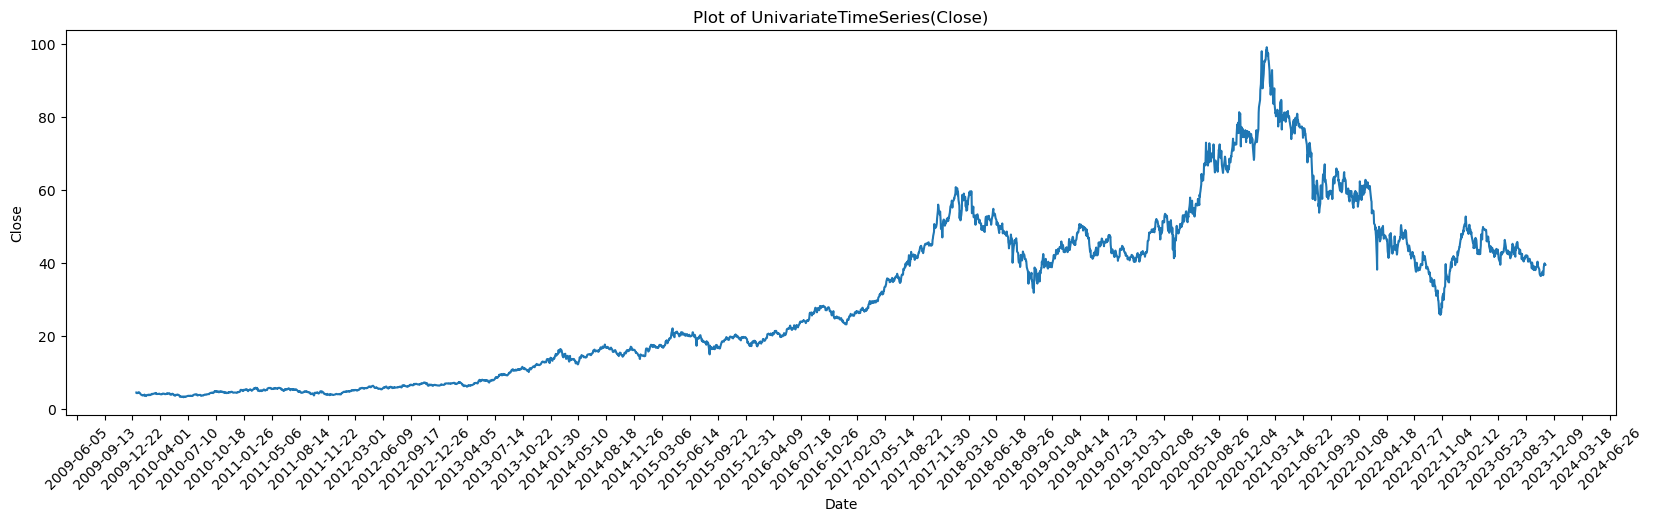

In [44]:
stocks[stock_symbol].plot(tick_skip=100)

- Tencent went public Jan 4, 2010 [yfinance](https://finance.yahoo.com/quote/TCEHY/history?period1=1262649600&period2=1698537600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true).
- What happened in 2018 for the Tencent stock close observations to fall?
    - See milestones [Tencent](https://www.tencent.com/en-us/about.html#about-con-2). Which milestones seem contradictory to this fall?
- What happened in 2020 for the Tencent stock close observations to fall?
    - Covid-19, so what happened in China during Covid? How did customers and end users react to company during the pandemic?
    - See milestones [Tencent](https://www.tencent.com/en-us/about.html#about-con-2). Which milestones seem contradictory to this fall?
- What's the future of the China market? Tencent?
- How long will it take for Tencent to see another peak stock close observation?

<AxesSubplot: xlabel='Date'>

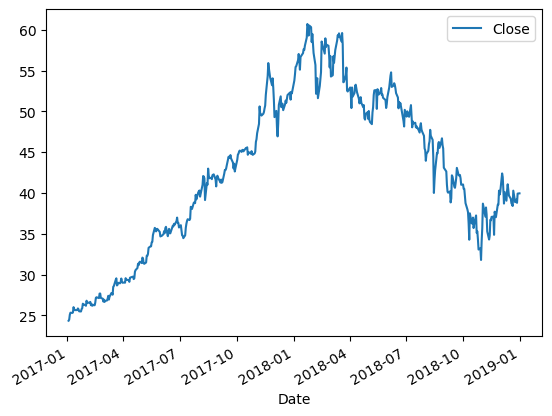

In [45]:
stock_df.loc['2017-01-01':'2019-01-01'].plot()

### Get Descriptive Statistics of Raw Data

In [46]:
stocks[stock_symbol].get_statistics()

,Close
count,3487.000000
mean,30.598971
std,22.328067
min,3.182000
25%,7.826000
50%,26.379999
75%,46.525000
max,99.010002


In [47]:
stocks[stock_symbol].max_min_range()

{'Max': Close    99.010002
 dtype: float64,
 'Min': Close    3.182
 dtype: float64,
 'Range': Close    95.828002
 dtype: float64}

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary.
    - Can we verify this non-stationary with plotting the Autocorrelation?

In [48]:
stocks[stock_symbol].stationarity_test(stock_df)

ADF Statistic: -1.274416
p-value: 0.640794 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

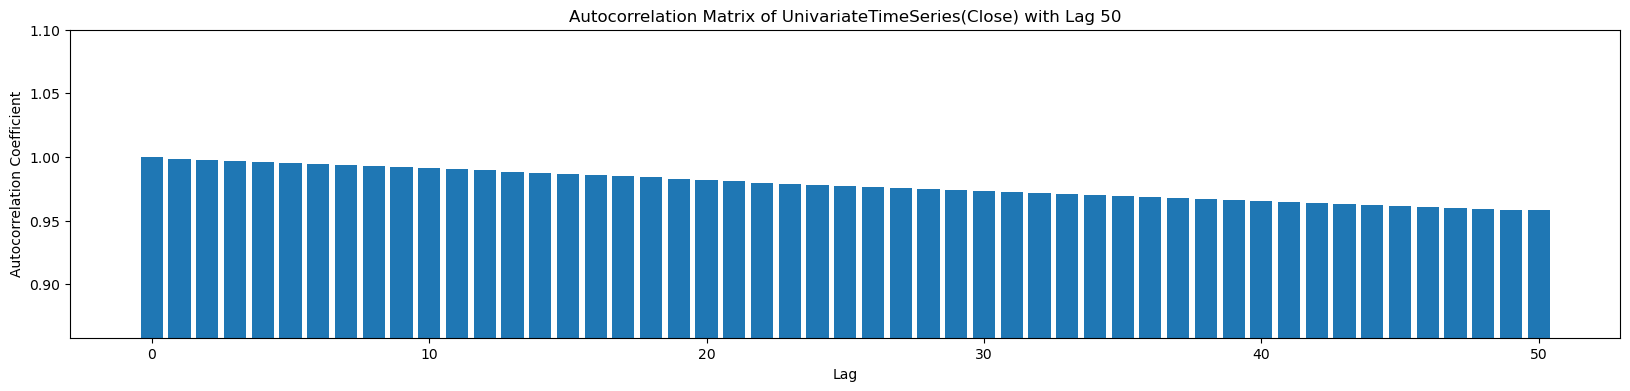

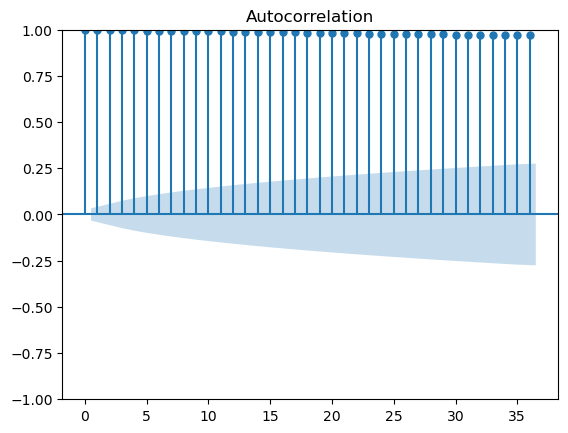

In [49]:
stocks[stock_symbol].plot_autocorrelation(50)

- Above, the data is highly correlated which means that the k-th lag observation has some impact on the most recent observation.

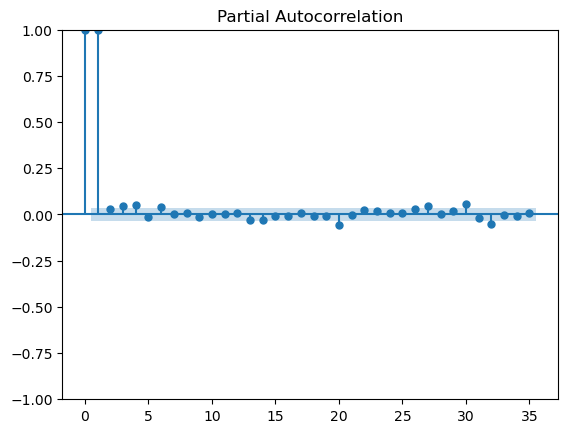

In [50]:
stocks[stock_symbol].plot_partial_autocorrelation(35)

- Above, the data shows a rapid decay at lag 2. 

### Get Returns Data

- Forecast returns
- Why: To have more stationarity (for the returns) compared to the prices `Open`/`Close` which is non-stationary
- Calculate with the `change` between $ z_t $ and $ z_{t-1} $
$$ Change = ((z_t - z_{t-1}) \div | z_{t-1} |) \space \rightarrow decimal \space form $$
$$ Percent \space Change = Change \times 100 \space \rightarrow pecent \space form $$
    - If `change` < 0, then stock price is going down, hence a **loss** from $ z_{t-1} \rightarrow z_t $
    - If `change` > 0, then stock price is going up, hence a **gain** from $ z_{t-1} \rightarrow z_t $
    - If `change` = 0, then stock price is constant, hence a **no loss nor no gain** from $ z_{t-1} \rightarrow z_t $
- NOTE: Shift the date by 1 because we don't have anything to subtract the 0th date by.

In [51]:
stock_returns = stocks[stock_symbol].data_augment_for_returns()
stock_returns

UnivariateTimeSeries(Returns)

In [52]:
stock_returns_df = stock_returns.get_as_df()
stock_returns_df

,Returns
Date,
2010-01-06,0.001341
2010-01-07,-0.040625
2010-01-08,-0.001861
2010-01-11,0.034965
2010-01-12,-0.011261
...,...
2023-11-03,0.044624
2023-11-06,0.025476
2023-11-07,-0.011543


### Plot Returns Data

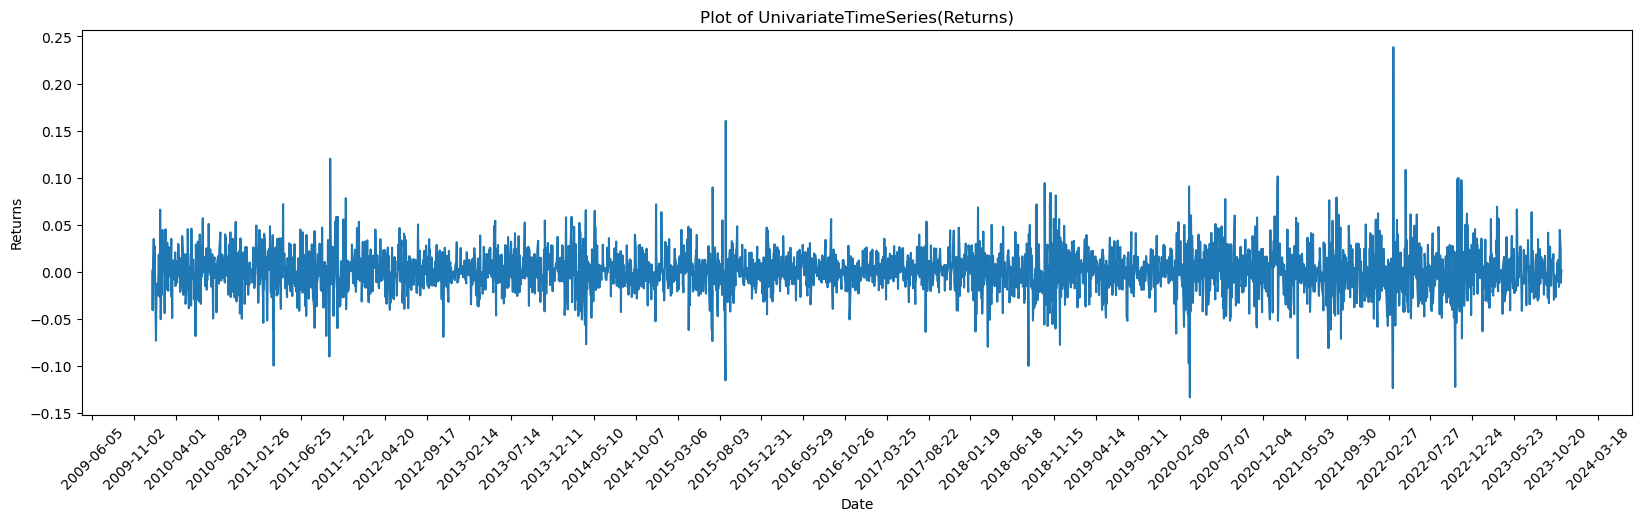

In [53]:
stock_returns.plot(tick_skip=150)

- Returns seem to have constant mean and constant variance although there are larger increases in 2015, 2019/2020, and Q1 & Q2 of 2022.

### Get Descriptive Statistics of Returns Data

In [54]:
stock_returns.get_statistics()

,Returns
count,3486.000000
mean,0.000891
std,0.023149
min,-0.133039
25%,-0.011026
50%,0.000670
75%,0.013386
max,0.238520


### Check Stationarity of Returns Data

In [55]:
stock_returns.stationarity_test(stock_returns_df)

ADF Statistic: -29.035658
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the TS is stationary
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### Plot Autocorrelation and Partial Autocorrelation of Returns Data

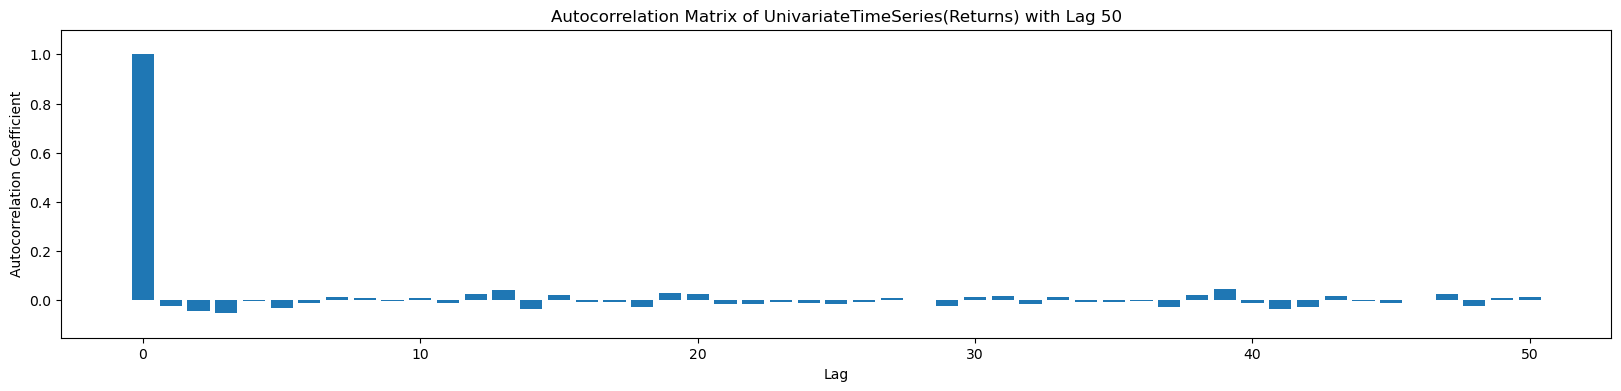

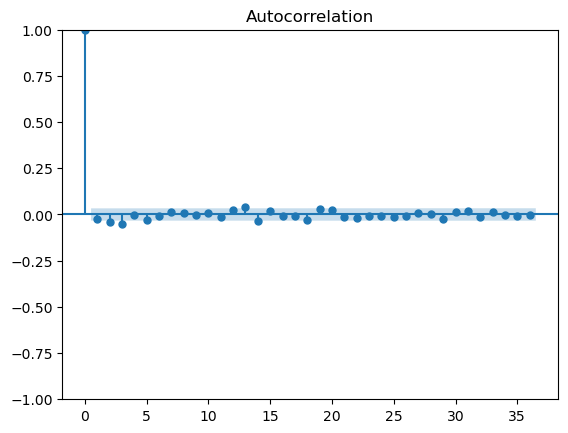

In [56]:
stock_returns.plot_autocorrelation(50)

- The ACorr rapidly decays as lag observation 1, so if we use an MA, we'd go with MA(1).

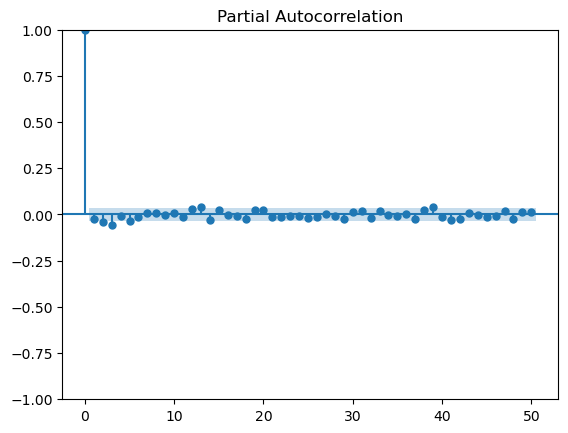

In [57]:
stock_returns.plot_partial_autocorrelation(50)

- The Partial ACorr rapidly decays as lag observation 1, so if we use an MA, we'd go with AR(1).

### Split Returns Data

- Splitting so we can forecast the last 7 days. Do this type of forecast to see how model is performing. If model performs how we need, then update notebook to forecast the next 7 days.

In [58]:
stock_returns_len = len(stock_returns_df)
stock_returns_len

3486

In [67]:
get_train_len = len(stock_returns_df[:3479])
get_train_len

3479

In [68]:
get_train_percentage = float(get_train_len / stock_returns_len)
get_train_percentage

0.9979919678714859

In [69]:
train, validation, test = stock_returns.get_train_validation_test_split(get_train_percentage, 0.0)

0 3479
3479 3479
3479 3486


In [70]:
train

UnivariateTimeSeries(UnivariateTimeSeries(Returns)[0:3479])

In [71]:
train.get_as_df()

,UnivariateTimeSeries(Returns)[0:3479]
Date,
2010-01-06,0.001341
2010-01-07,-0.040625
2010-01-08,-0.001861
2010-01-11,0.034965
2010-01-12,-0.011261
...,...
2023-10-25,0.009338
2023-10-26,-0.001905
2023-10-27,0.012541


In [72]:
test

UnivariateTimeSeries(UnivariateTimeSeries(Returns)[3479:3486])

In [83]:
test.get_as_df()

,UnivariateTimeSeries(Returns)[3479:3486]
Date,
2023-11-01,-0.011081
2023-11-02,0.016671
2023-11-03,0.044624
2023-11-06,0.025476
2023-11-07,-0.011543
2023-11-08,-0.000508
2023-11-09,0.001524


In [84]:
expected_forecast = test.get_series()
expected_forecast

array([-0.01108108,  0.01667124,  0.04462365,  0.02547601, -0.01154326,
       -0.00050775,  0.00152404])

### Initialize Autoregressive AR(p) Model

- How to determine the proper lag value? Look at the Partial ACor plot.

In [75]:
positive_pacor = [1, 2]
negative_pacor = []
lags_to_test = positive_pacor + negative_pacor
lags_to_test = sorted(lags_to_test)
lags_to_test

[1, 2]

In [76]:
# create an object from the AR() class
ar_model_class = AR()

# call the function to train our AR model
trained_ar_models = ar_model_class.train_ar_model(train.get_series(), lags_to_test)

Model 1 with a lag of 1
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3479
Model:                     AutoReg(1)   Log Likelihood                8162.994
Method:               Conditional MLE   S.D. of innovations              0.023
Date:                Sat, 11 Nov 2023   AIC                         -16319.988
Time:                        23:41:58   BIC                         -16301.525
Sample:                             1   HQIC                        -16313.397
                                 3479                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.285      0.022       0.000       0.002
y.L1          -0.0262      0.017     -1.548      0.122      -0.059       0.007
                            

In [77]:
len_historical_data, historical_data = train.get_historical_data()
len_historical_data

3479

### Predict Forecasts of Retruns Data

In [78]:
end = len(stock_df)

In [85]:
predictions = ar_model_class.predict(trained_ar_models, len_historical_data + 2, end)
predictions

Model 1 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a06483a0>
Model 2 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a10ab610>


[array([0.00087468, 0.00087437, 0.00087437, 0.00087437, 0.00087437,
        0.00087437, 0.00087437]),
 array([0.00086721, 0.00085631, 0.00088717, 0.00088679, 0.0008855 ,
        0.00088555, 0.0008856 ])]

In [86]:
mse_gsts = EvaluationMetric.eval_mse(expected_forecast, predictions)
mse_gsts

expected [-0.01108108  0.01667124  0.04462365  0.02547601 -0.01154326 -0.00050775
  0.00152404] predicted [0.00087468 0.00087437 0.00087437 0.00087437 0.00087437 0.00087437
 0.00087437] mse 0.00043832159282885267
expected [-0.01108108  0.01667124  0.04462365  0.02547601 -0.01154326 -0.00050775
  0.00152404] predicted [0.00086721 0.00085631 0.00088717 0.00088679 0.0008855  0.00088555
 0.0008856 ] mse 0.0004381723145444963


### Plot Actual Forecasts vs Predicted Forecasts for Returns Data

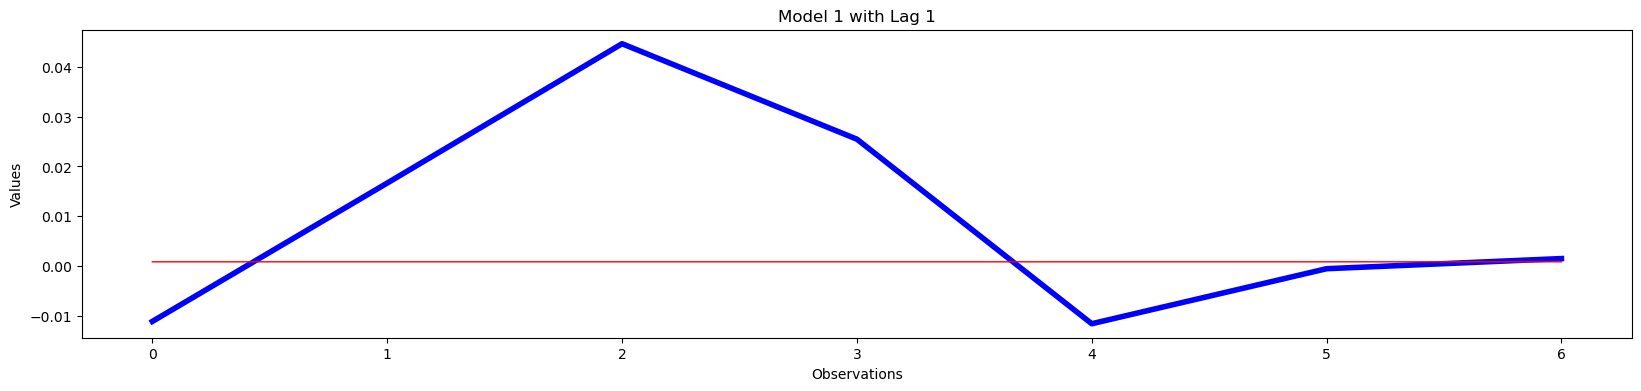

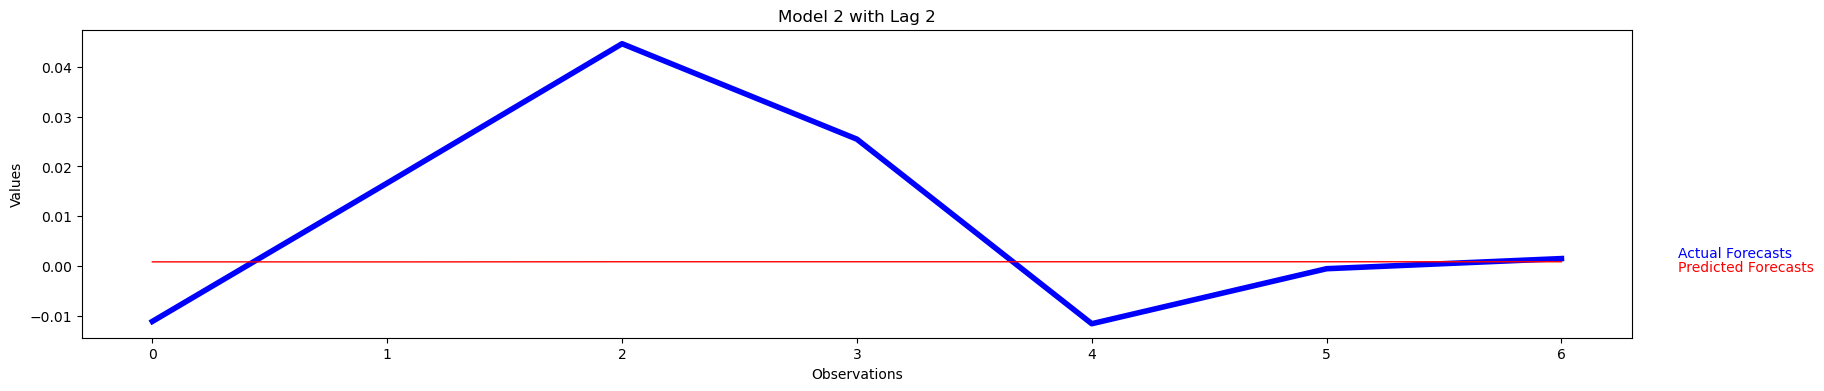

In [87]:
EvaluationMetric.plot_forecast(expected_forecast, predictions, lags_to_test)

### Initialize Moving Average MA(q) Model

In [36]:
test_error_terms = [1, 13, 18, 35]

In [37]:
# create an object from the MA() class
ma_model_class = MA()

# call the function to train our AR model
trained_ma_models = ma_model_class.train_model(train.get_series(), test_error_terms)

MA( 1 )
MA( 13 )
MA( 18 )
MA( 35 )


In [38]:
len_historical_data, historical_data = train.get_historical_data()
len_historical_data

3465

### Predict Forecasts of Returns Data

In [39]:
ma_predictions = ma_model_class.predict(trained_ma_models, len_historical_data, train, test)
ma_predictions

MA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1a8871370> )
MA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1a88fcf40> )
MA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1a8871760> )
MA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1a890edc0> )


[array([-0.00033625,  0.00053053,  0.0011541 ,  0.00118033,  0.00075995,
         0.00146289,  0.00056065]),
 array([-0.00033625,  0.00053053,  0.0011541 ,  0.00118033,  0.00075995,
         0.00146289,  0.00056065]),
 array([-0.00033625,  0.00053053,  0.0011541 ,  0.00118033,  0.00075995,
         0.00146289,  0.00056065]),
 array([-0.00033625,  0.00053053,  0.0011541 ,  0.00118033,  0.00075995,
         0.00146289,  0.00056065])]

In [40]:
mse_gsts = EvaluationMetric.eval_mse(expected_forecast, ma_predictions)
mse_gsts

expected [ 0.00099381 -0.02953592 -0.01534523 -0.00363635 -0.00417101 -0.02670158
 -0.01156537] predicted [-0.00033625  0.00053053  0.0011541   0.00118033  0.00075995  0.00146289
  0.00056065] mse 0.0003093972752065683
expected [ 0.00099381 -0.02953592 -0.01534523 -0.00363635 -0.00417101 -0.02670158
 -0.01156537] predicted [-0.00033625  0.00053053  0.0011541   0.00118033  0.00075995  0.00146289
  0.00056065] mse 0.0003093972752065683
expected [ 0.00099381 -0.02953592 -0.01534523 -0.00363635 -0.00417101 -0.02670158
 -0.01156537] predicted [-0.00033625  0.00053053  0.0011541   0.00118033  0.00075995  0.00146289
  0.00056065] mse 0.0003093972752065683
expected [ 0.00099381 -0.02953592 -0.01534523 -0.00363635 -0.00417101 -0.02670158
 -0.01156537] predicted [-0.00033625  0.00053053  0.0011541   0.00118033  0.00075995  0.00146289
  0.00056065] mse 0.0003093972752065683


### Plot Actual Forecasts vs Predicted Forecasts for Returns Data

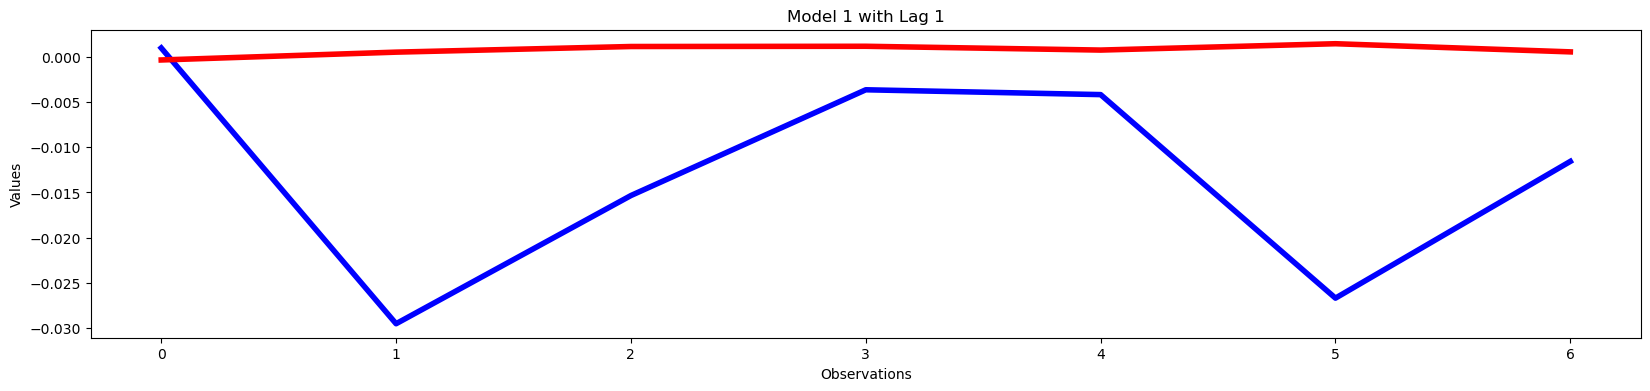

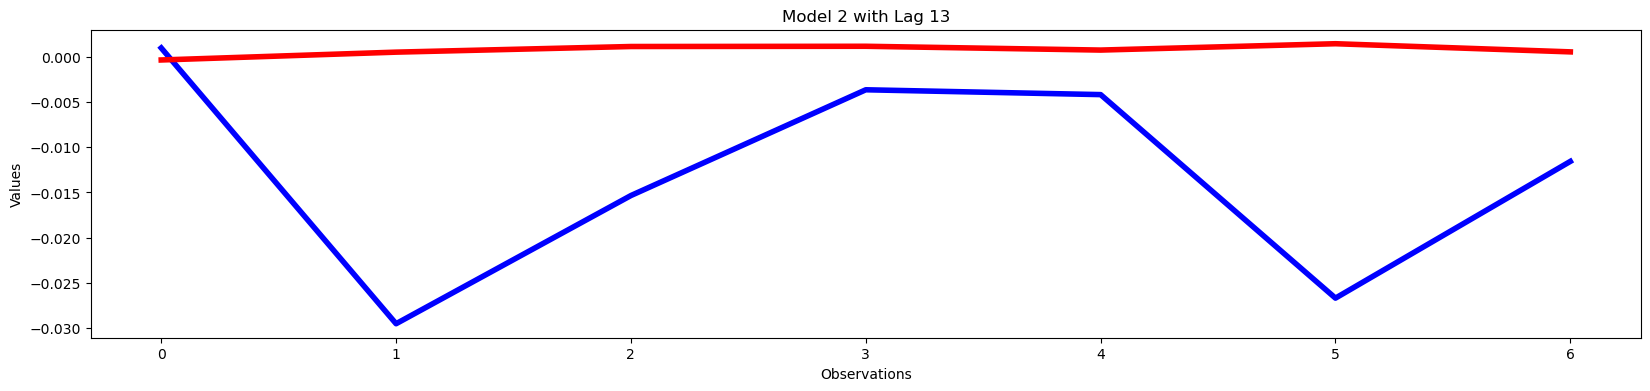

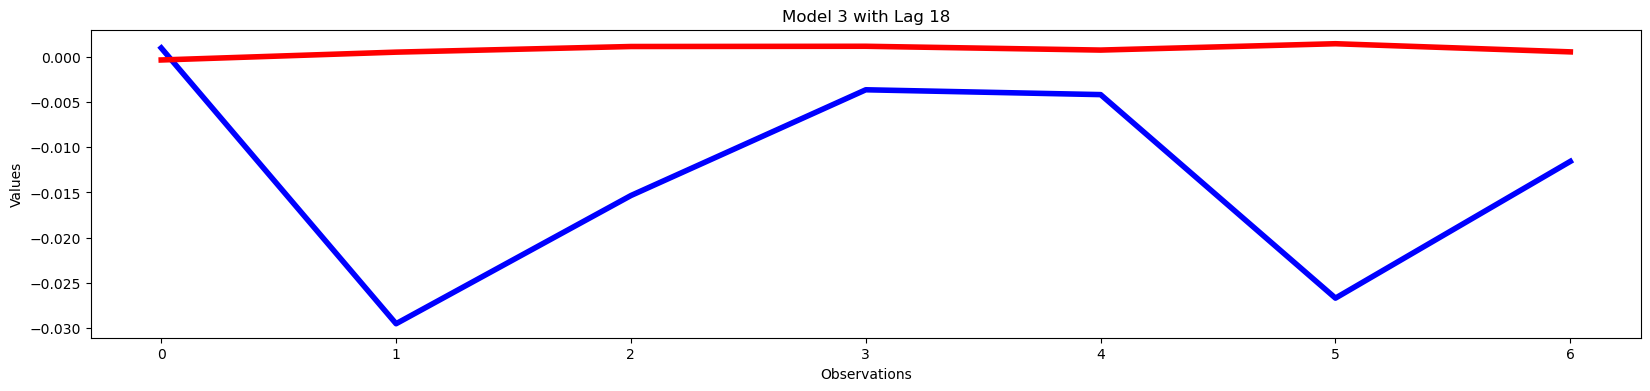

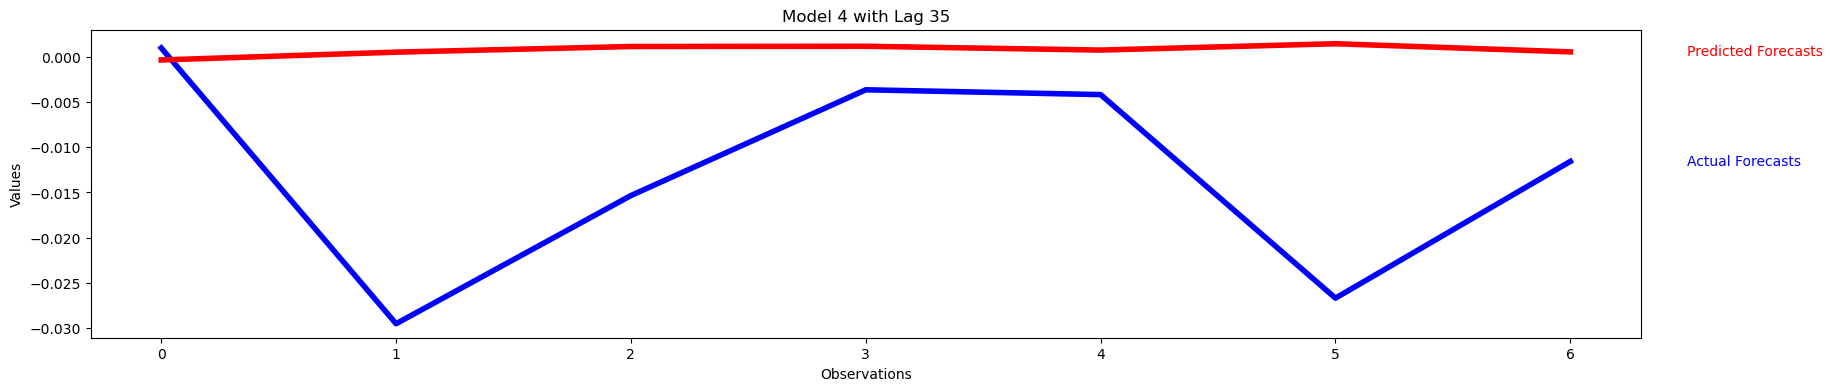

In [41]:
EvaluationMetric.plot_forecast(expected_forecast, ma_predictions, test_error_terms)

### Initialize Moving Average ARMA(p, q) Model

In [42]:
lags_to_test

[1]

In [43]:
test_error_terms = [1]
test_error_terms

[1]

In [44]:
# create an object from the ARMA() class
arma_model_class = ARMA()

# call the function to train our AR model
trained_arma_models = arma_model_class.train_arma_model(train.get_series(), lags_to_test, test_error_terms)

ARMA( 1 0 1 )
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3465
Model:                 ARIMA(1, 1, 1)   Log Likelihood                8121.879
Date:                Tue, 07 Nov 2023   AIC                         -16237.758
Time:                        16:18:15   BIC                         -16219.308
Sample:                             0   HQIC                        -16231.170
                               - 3465                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0268      0.011     -2.362      0.018      -0.049      -0.005
ma.L1         -0.9999      0.019    -51.316      0.000      -1.038      -0.962
sigma2         0.0005   1.34e-05     3

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
len_historical_data, historical_data = train.get_historical_data()
len_historical_data

3465

### Predict Forecasts of Returns Data

In [46]:
arma_predictions = arma_model_class.predict(trained_arma_models, len_historical_data, train, test)
arma_predictions

ARMA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1a890e430> )


[array([5.94482858e-05, 5.66106032e-04, 5.52543927e-04, 5.52906955e-04,
        5.52897237e-04, 5.52897497e-04, 5.52897490e-04])]

In [47]:
mse_gsts = EvaluationMetric.eval_mse(expected_forecast, arma_predictions)
mse_gsts

expected [ 0.00099381 -0.02953592 -0.01534523 -0.00363635 -0.00417101 -0.02670158
 -0.01156537] predicted [5.94482858e-05 5.66106032e-04 5.52543927e-04 5.52906955e-04
 5.52897237e-04 5.52897497e-04 5.52897490e-04] mse 0.0002984669452817376


### Plot Actual Forecasts vs Predicted Forecasts for Returns Data

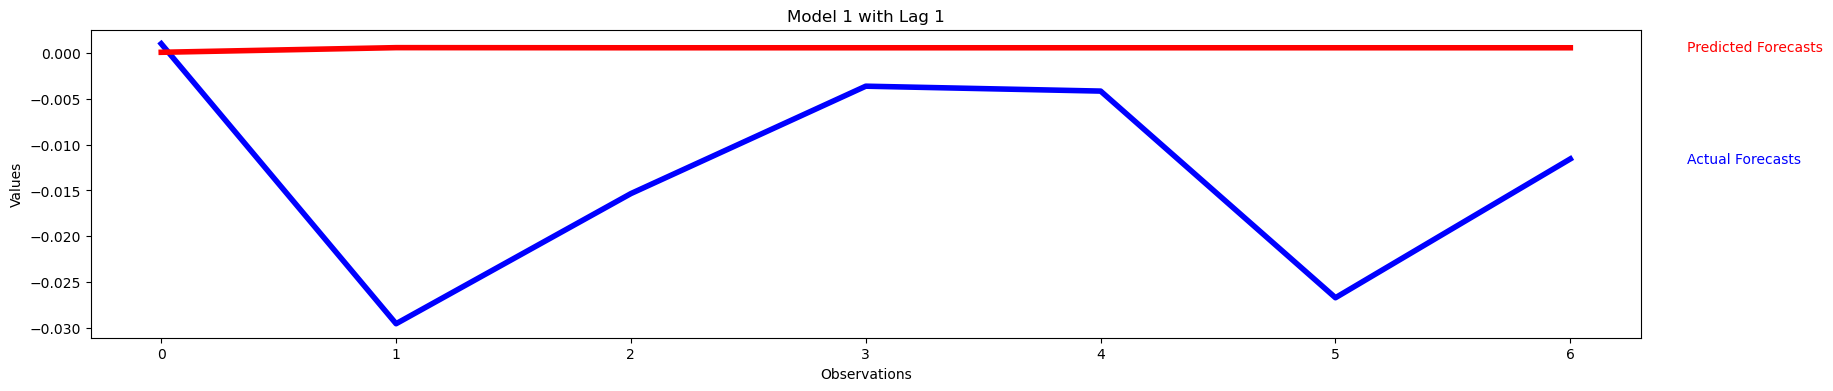

In [48]:
EvaluationMetric.plot_forecast(expected_forecast, arma_predictions, lags_to_test)

### Initialize Persistence Random Walk Model

In [49]:
# create an object from the PersistenceWalkForward() class
random_walk_model = PersistenceWalkForward()

In [50]:
stock_returns_df

,Returns
Date,
2010-01-06,0.001341
2010-01-07,-0.040625
2010-01-08,-0.001861
2010-01-11,0.034965
2010-01-12,-0.011261
...,...
2023-10-16,-0.015345
2023-10-17,-0.003636
2023-10-18,-0.004171


In [51]:
stock_returns.get_series()

array([ 0.00134109, -0.04062504, -0.00186131, ..., -0.00417101,
       -0.02670158, -0.01156537])

In [52]:
stock_returns_lags_df = random_walk_model.augment_data(stock_returns_df, 1)
stock_returns_lags_df

,t - 1,t + 1
Date,,
2010-01-06,NaN,0.001341
2010-01-07,0.001341,-0.040625
2010-01-08,-0.040625,-0.001861
2010-01-11,-0.001861,0.034965
2010-01-12,0.034965,-0.011261
...,...,...
2023-10-16,-0.029536,-0.015345
2023-10-17,-0.015345,-0.003636
2023-10-18,-0.003636,-0.004171


In [53]:
X = stock_returns_lags_df.values
X

array([[        nan,  0.00134109],
       [ 0.00134109, -0.04062504],
       [-0.04062504, -0.00186131],
       ...,
       [-0.00363635, -0.00417101],
       [-0.00417101, -0.02670158],
       [-0.02670158, -0.01156537]])

In [54]:
# start at 1 to drop nan
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [55]:
import numpy as np

### Predict Forecasts of Returns Data

In [56]:
prw_predictions = random_walk_model.predict(test_X)
prw_predictions = np.array(prw_predictions)
prw_predictions

Predicted Forecasts: [0.018987341772152]
Predicted Forecasts: [0.018987341772152, 0.0009938115658967295]
Predicted Forecasts: [0.018987341772152, 0.0009938115658967295, -0.02953592490358159]
Predicted Forecasts: [0.018987341772152, 0.0009938115658967295, -0.02953592490358159, -0.015345230116011632]
Predicted Forecasts: [0.018987341772152, 0.0009938115658967295, -0.02953592490358159, -0.015345230116011632, -0.0036363477830763102]
Predicted Forecasts: [0.018987341772152, 0.0009938115658967295, -0.02953592490358159, -0.015345230116011632, -0.0036363477830763102, -0.004171007426129525]
Predicted Forecasts: [0.018987341772152, 0.0009938115658967295, -0.02953592490358159, -0.015345230116011632, -0.0036363477830763102, -0.004171007426129525, -0.02670158213068019]


array([ 0.01898734,  0.00099381, -0.02953592, -0.01534523, -0.00363635,
       -0.00417101, -0.02670158])

In [57]:
mse_stock_returns = EvaluationMetric.eval_mse(test_y, prw_predictions, per_element=False)
mse_stock_returns

Test MSE: 0.000


### Plot Actual Forecasts vs Predicted Forecasts for Returns Data

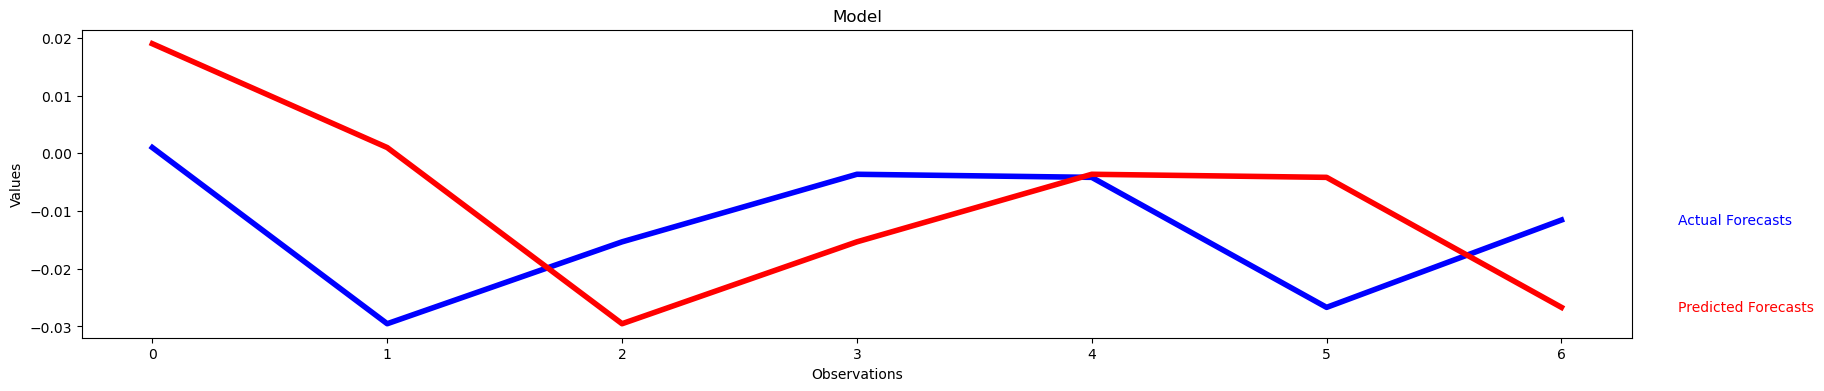

In [58]:
lags_to_test = []
EvaluationMetric.plot_forecast(test_y, prw_predictions, lags_to_test, with_lags=False)

### Follow-up
- What can we determine from this?
    - `AR`, `MA`, `ARMA` aren't perfoming so well on the returns data. Do I need to convert back to the raw data?
    - `Persistence RW` model on the returns mse is at 0 but the plot isn't directly aligning. There are minor errors here.
- Which AR(p) lag performs the best?
    - Difficult to state. 
- Can we do better?
    - We must lol!
- What to consider?
    - [ ] Log Likelihood
    - [ ] AIC
    - [ ] BIC
    - [ ] HQIC
    - [ ] Ljung-Box (L1) (Q)
    - [ ] Jarque-Bera (JB)
    - [ ] Prob(Q):
    - [ ] Prob(JB):
    - [ ] Heteroskedasticity (H):
    - [ ] Skew
    - [ ] Prob(H) (two-sided)
    - [ ] Kurtosis